<a href="https://colab.research.google.com/github/HamidrezaKmK/ML-Mnemonist/blob/main/ExperimentRunnerTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup hosted runtime

In [1]:
%%writefile sys_setup.py
#!usr/bin/bash python

import sys
from google.colab import drive
import subprocess
import os
import shutil

PROJ_NAME = 'ML-Mnemonist'
GIT_DIR = 'HamidrezaKmK'

data_dir = None

if __name__ == '__main__':
  env = os.environ.copy()
  if not os.path.exists('/content/drive'):
    print("Mounting drive...")
    drive.mount('/content/drive')
    print("Mount complete!")

  while True:
    opt = input("What are you trying to do? [clone/pull] ")
    if opt == 'clone':
      addr = f"https://github.com/{GIT_DIR}/{PROJ_NAME}"
      print(f"Trying to connect to {addr}")
      token = input("Enter token: ")
      addr = addr.replace('[TOKEN]', token)
      res = subprocess.run(['git', 'clone', addr], env=env, capture_output=True)
      print(res.stdout.decode())
      print(res.stderr.decode())
      break
    elif opt == 'pull':
      path = os.path.join('/content', PROJ_NAME)
      os.chdir(path)
      res = subprocess.run(['git', 'pull'], env=env, capture_output=True)
      print(res.stdout.decode())
      print(res.stderr.decode())
      break
    elif opt == '':
      print("Nothing happened!")
      break
  
  if not os.path.exists(f'/content/{PROJ_NAME}'):
    raise RuntimeError("No project repository available!")

  if not os.path.exists(f'/content/{PROJ_NAME}/.env'):
    print("Dotenv non-existant!")
    while True:
      resp = input("Do you want to enter the file in the prompt or copy it?\n[copy/write] ")
      if resp == 'copy':
        dir = input("Enter the directory to copy: ")
        shutil.copyfile(dir, f'/content/{PROJ_NAME}/.env')
      elif resp == 'write':
        print("Enter the lines in format ENV_VARIABLE_NAME=VALUE")
        print("End with: ENDFILE")
        with open(f'/content/{PROJ_NAME}/.env', 'w') as f:
          while True:
            line = input()
            if line == 'ENDFILE':
              break
            f.write(f'{line}\n')
      else:
        continue
      break
        
  os.chdir('/content')


Writing sys_setup.py


In [23]:
PROJ_NAME = 'ML-Mnemonist'

from IPython.display import clear_output
%run /content/sys_setup.py
resp = input("Do you want to install packages? [y/n] ")
if resp == 'y':
  !pip install -r /content/ML-Mnemonist/requirements.txt
  input("Requrements installed! -- press any key to continue ...")
clear_output()

import sys
sys.path.append(f'/content/{PROJ_NAME}')
os.chdir(f'/content/{PROJ_NAME}')
print("Running complete!")

Running complete!


<Figure size 432x288 with 0 Axes>

# Local Runtime

In [3]:
import sys
sys.path.append('.')

# Experiment runner

Create a runner factory. This factory has the ability to create your runners. The factory automatically fills up the environment variables using the `.env` file provided. 

It fills up the following:
- `config_dir`: A path containing all your configuration `yaml` files.
- `experiment_dir`: A path containing all your experiments. The result of all the experiments will be stored as directories in this path.
- `checkpoint_dir`: A path containing all the model checkpoints which is used for cached run functions.

In [1]:
from mlmnemonist.experiment_factory import ExperimentRunnerFactory
from testing.config.config import get_cfg_defaults

factory = ExperimentRunnerFactory(cfg_base=get_cfg_defaults())


In [2]:
token = None
token = '2'
description = """
An experiment built for testing the ML-Mnemonist
"""
runner = factory.create(description=description,
                        cfg_dir='conf-test.yaml',
                        verbose=1, cache_token=token
                        )

In [2]:
runner = factory.retrieve('2')

In [9]:
del runner

In [3]:
print(runner)

Runner at /home/hamidreza/myprojects/ML-Mnemonist/testing/mnemonic-experiments/2022-07-01-exp-2
	 - cache token: 2
	 - configurations at: /home/hamidreza/myprojects/ML-Mnemonist/testing/config/conf-test.yaml
	 - preprocessings functions []
	 - recurring pipeline []
	 - Run function not implemented!


# Run a simple linear regression program



In [4]:
from mlmnemonist.experiment_runner import ExperimentRunner
import pandas as pd
import os

In [5]:
runner.preprocessing_pipeline.clear_functions()

In [6]:
def load_raw_data(runner: ExperimentRunner):
  train_name = runner.cfg.DATASET.TRAIN_NAME
  test_name = runner.cfg.DATASET.TEST_NAME
  runner.train_df = pd.read_csv(runner.reveal_true_path(train_name))
  runner.test_df = pd.read_csv(runner.reveal_true_path(test_name))
runner.preprocessing_pipeline.update_function(load_raw_data)

In [7]:
def process_data(runner: ExperimentRunner):
  runner.train_X = runner.train_df.drop(columns='median_house_value').to_numpy()
  runner.train_Y = runner.train_df['median_house_value'].to_numpy()
  runner.test_X = runner.test_df.drop(columns='median_house_value').to_numpy()
  runner.test_Y = runner.test_df['median_house_value'].to_numpy()
runner.preprocessing_pipeline.update_function(process_data)

In [8]:
print(runner)

Runner at /home/hamidreza/myprojects/ML-Mnemonist/testing/mnemonic-experiments/2022-07-01-exp-2
	 - cache token: 2
	 - configurations at: /home/hamidreza/myprojects/ML-Mnemonist/testing/config/conf-test.yaml
	 - preprocessings functions ['load_raw_data', 'process_data']
	 - recurring pipeline []
	 - Run function not implemented!


In [9]:
# Run the functions in line
runner.preprocess()

[1/2] Running load_raw_data
[2/2] Running process_data


## Create a model

All models are stored in the `src.modeling` directory. Each modeling file should contain a registry that will give us access to different model types using a configuration. 

For example, in `conf-test.yaml` we defined an MLP with 3 layers and certain hyper parameters. The following functions are part of preprocessing and setup our model.


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyMLP(nn.Module):
    def __init__(self, input_features: int, hidden_layer_1: int, hidden_layer_2: int):
        super(MyMLP, self).__init__()
        self.l1 = nn.Linear(input_features, hidden_layer_1)
        self.l2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.l3 = nn.Linear(hidden_layer_2, 1)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        return x


In [11]:
import torch
def setup_device(runner: ExperimentRunner):
  # extract the device from config
  device = runner.cfg.SOLVER.DEVICE
  if device == 'cpu':
    runner.device = torch.device('cpu')
  elif device == 'cuda' and torch.cuda.is_available():
    runner.device = torch.device('cuda')
  else:
    raise NotImplementedError(f"device {device} is not implemented!")
runner.recurring_pipeline.update_function(setup_device)

In [12]:

def setup_model(runner: ExperimentRunner):
  # extract the method from config
  method = runner.cfg.SOLVER.METHOD
  # construct the model from registry
  cfg_h_params = runner.cfg.MODEL.HYPER_PARAMETERS
  my_model = MyMLP(input_features=cfg_h_params.IN_FEATURES,
                   hidden_layer_1=cfg_h_params.H1,
                   hidden_layer_2=cfg_h_params.H2)
  # set the function in the cache to save weights
  my_model = runner.CACHE.SET_M('mlp-key', my_model)
  my_model.to(runner.device)
  if runner.verbose > 0:
    print("Model state dict")
    print(my_model)
runner.recurring_pipeline.update_function(setup_model)

In [13]:
import torch
import torch.nn as nn

def setup_training(runner: ExperimentRunner):
  my_model = runner.CACHE.GET_M('mlp-key').to(runner.device)
  runner.criterion = nn.MSELoss()
  if runner.cfg.SOLVER.OPTIMIZER_TYPE == 'adam':
    runner.optim = torch.optim.Adam(my_model.parameters(), lr=runner.cfg.SOLVER.LR)
  else:
    raise NotImplementedError(f"Optimizer type not implemented"
                              f"{runner.cfg.SOLVER.OPTIMIZER_TYPE}")
runner.recurring_pipeline.update_function(setup_training)

In [14]:
print(runner)

Runner at /home/hamidreza/myprojects/ML-Mnemonist/testing/mnemonic-experiments/2022-07-01-exp-2
	 - cache token: 2
	 - configurations at: /home/hamidreza/myprojects/ML-Mnemonist/testing/config/conf-test.yaml
	 - preprocessings functions ['load_raw_data', 'process_data']
	 - recurring pipeline ['setup_device', 'setup_model', 'setup_training']
	 - Run function not implemented!


# Implement a run function

A run function is the core part of an experiment. This function takes in an input of type `ExperimentRunner` type is its first element and a bunch of arbitrary input types for the rest.


In [23]:
runner.CACHE.RESET()

In [15]:
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

def helper(model, X, y, history, device, loss_fn, optimizer=None):
  for st in range(0, X.shape[0], 500):
    en = min(st + 500, X.shape[0])
    X_ = torch.from_numpy(X[st:en, :]).float().to(device)
    pred = model(X_)
    y_ = torch.from_numpy(y[st:en]).float().to(device)
    loss = loss_fn(pred.squeeze(), y_)
    if optimizer is not None:
      loss.backward()
      optimizer.step()
    history.append(loss.detach().cpu().item())
    
def my_custom_run(runner: ExperimentRunner, show_freq=50):
  # print(runner.CACHE._cached_primitives)
  # return
  # Get model from cache
  my_model = runner.CACHE.GET_M('mlp-key')

  # Get the epoch number and history from cache
  # if it is not cached from before set it to zero
  epoch_i = runner.CACHE.SET_IFN('epoch_i', 0)
  loss_history = runner.CACHE.SET_IFN('loss-history', [[], []])
  writer = SummaryWriter(log_dir=runner.CACHE.LOGS_DIR)
  for epoch_i in range(epoch_i, 10000):

    inds = np.arange(runner.train_X.shape[0])
    np.random.shuffle(inds)

    loss_train = []
    my_model.train()
    helper(my_model, runner.train_X[inds],
           runner.train_Y[inds], loss_train, runner.device,
           runner.criterion, runner.optim)
    mean_loss = sum(loss_train) / len(loss_train)
    loss_history[0].append(mean_loss)
    train_loss = mean_loss
    loss_test = []
    my_model.eval()
    with torch.no_grad():
      helper(my_model, runner.test_X,
            runner.test_Y, loss_test, runner.device,
            runner.criterion)
    mean_loss = sum(loss_test) / len(loss_test)
    loss_history[1].append(mean_loss)
    test_loss = mean_loss
    writer.add_scalars('losses', {
      'train': train_loss,
      'test': test_loss
    }, epoch_i)
    if (epoch_i + 1) % show_freq == 0:
      clear_output()
      plt.plot(list(range(len(loss_history[0]))), loss_history[0], label='loss-train')
      plt.plot(list(range(len(loss_history[1]))), loss_history[1], label='loss-test')
      plt.legend()
      plt.show()

    # Caching and saving checkpoints
    runner.CACHE.SET('epoch_i', epoch_i)
    runner.CACHE.SET('loss-history', loss_history)
    runner.CACHE.SET_M('mlp-key', my_model)
    runner.CACHE.SAVE()

runner.implement_run(my_custom_run)

Run the following function to see the training and validation loss.
Interrupt the process for as many times as you like and re-run it. Since the code supports caching, it will continue right off where it last ended.

In [17]:
del runner

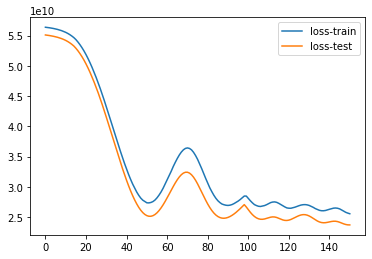

KeyboardInterrupt: 

In [16]:
runner.run(show_freq=10)

# Export tensorboard logs

In [18]:
runner.export_logs()

Files being archived in /home/hamidreza/myprojects/ML-Mnemonist/testing/mnemonic-experiments/my_first_experiment/logs-export.zip ...


'/home/hamidreza/myprojects/ML-Mnemonist/testing/mnemonic-experiments/my_first_experiment/logs-export.zip'

# Run even after the session is closed

Each runner has a cache token associated with it. You can checkout your runner's token using the following function:

In [19]:
runner.CACHE.TOKEN

'1-MLM-CACHE-TOK'

Now re-run your session and when you are creating a runner use the token in the `cache_token=YOUR_TOKEN` variable. That way, when you call `load_cache()` or whenever you re-run the `run()` function. All the variables that have been cached will be reloaded again.